In [1]:
import pandas as pd
import joblib
import numpy as np
import pandas as pd
from torch import nn
import torch
import os
import torch.optim as optim
import warnings 
from utils import *
warnings.simplefilter('ignore')
from torch.nn import Linear,ReLU,Sigmoid
torch.cuda.is_available()
os.listdir('../model')

['Critic.pkl', 'PAagent.pkl', 'stream_lasso_weight.pkl']

In [2]:
os.listdir('../data')

['dataset.pkl',
 'PA_201605-2020001更新R10(20200602).csv',
 'tag_cleaned.csv',
 'tag盤點表20200423.xlsx',
 'tag盤點表20200602R1.xlsx',
 'train_cleaned.csv',
 '反應槽(20200201-20200212)開車資料.csv']

In [3]:
tag = pd.read_csv('../data/tag_cleaned.csv')
tag_map = dict(zip(tag.TAG,tag.chinese))

# load critic , lasso_weight and data

In [4]:
critic = joblib.load('../model/Critic.pkl').eval()
lasso_w = torch.FloatTensor(joblib.load('../model/stream_lasso_weight.pkl'))

In [5]:
data = joblib.load('../data/dataset.pkl')
data.keys()

dict_keys(['state', 'action', 'output', 'stream', 'idx', 'mm_state', 'mm_action', 'mm_output', 'mm_stream', 'state_col', 'action_col', 'output_col', 'stream_col'])

# data iter

In [6]:
state = torch.FloatTensor(data['state'])
request = torch.FloatTensor(np.random.uniform(0,1,size=(state.shape[0],1)))
real_action = torch.FloatTensor(data['action'])
state.shape,request.shape,real_action.shape

(torch.Size([126443, 2]),
 torch.Size([126443, 1]),
 torch.Size([126443, 36, 11]))

In [7]:
train = torch.utils.data.TensorDataset(state,request,real_action)
train_iter = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)

# Construct the neural network

In [8]:
data['action'].shape

(126443, 36, 11)

In [9]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_step = data['action'].shape[1]
        self.num_sensor = data['action'].shape[2]
        self.flat_size = self.time_step*self.num_sensor
        self.fc = nn.Sequential(nn.Linear(3,128),nn.ReLU(),nn.Linear(128,self.flat_size))
        
    def forward(self,state,request):
        action = self.fc(torch.cat((state,request),dim=1))
        action = action.view(-1,self.time_step,self.num_sensor)
        return F.sigmoid(action)

In [10]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0)
        except:
            pass

In [11]:
net = Actor()
net.apply(init_weights)

Actor(
  (fc): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=396, bias=True)
  )
)

# forward test

In [12]:
print(net(state,request).shape)

torch.Size([126443, 36, 11])


# objective

In [13]:
time_step = data['action'].shape[1]
num_sensor = data['action'].shape[2]

In [14]:
loss_history = {}
loss_history['loss1'] = []
loss_history['loss2'] = []
loss_history['loss3'] = []
loss_history['loss4'] = []
loss_history['loss5'] = []
loss_history['loss6'] = []
loss_history['loss7'] = []

In [22]:
def obj_function(action,state,request,real_action):
    
    # critic predict 0997(output) but not predict stream
    output, _ = critic(state.cuda(),action.cuda())
    output = output.cpu()
    
    # only use lasso_w predict stream
    batch_size = action.shape[0]
    A = torch.cat((action.reshape(batch_size,-1),state),dim=-1)
    stream = (A@lasso_w).reshape(-1,1)
    
    # 滿足使用者需求(出料等於期望出料)
    loss1 = ((request - output)**2).mean()
    
    # 最小化蒸氣量(愈小愈好)
    loss2 = (stream**2).mean()
    
    # 入料跟出料"質量平衡"
    feed = action.reshape(-1,time_step,num_sensor)[:,:,0]
    loss3 = ((0.8*feed - request)**2).mean()
    
    # 避免鹽浴"溫差太大"
    temp_1 = action.reshape(-1,time_step,num_sensor)[:,:,4]
    temp_2 = action.reshape(-1,time_step,num_sensor)[:,:,-2]
    loss4 = ((temp_1 - temp_2)**2).mean()
    
    # 避免"變異數太大(時間維度上)"
    loss5 = action.reshape(-1,time_step,num_sensor).std(axis=1)
    loss5 = loss5.sum(axis=-1).mean(axis=0) # instance wise => batch wise
    
    #濃度盡量接近90
    loss6 = (action.reshape(-1,time_step,num_sensor)[:,:,-1] - 0.92)**2
    loss6 = loss6.mean()
    
    #避免action跟實際歷史數據差距太大
    loss7 = F.softplus((action.reshape(-1)-real_action.reshape(-1))**2 - 0.1,beta=5).mean()
    
    # 紀錄
    loss_history['loss1'].append(loss1.item())
    loss_history['loss2'].append(loss2.item())
    loss_history['loss3'].append(loss3.item())
    loss_history['loss4'].append(loss4.item())
    loss_history['loss5'].append(loss5.item())
    loss_history['loss6'].append(loss6.item())
    loss_history['loss7'].append(loss7.item())
    
    #由於最小化蒸氣量會導致入料跟著最小化會出問題 故將loss2*0
    return loss1 + 0*loss2 + loss3 + loss4 + loss5 + loss6 + loss7

In [23]:
obj_function(net(state,request),state,request,real_action)

tensor(0.6689, grad_fn=<AddBackward0>)

# optimizer

In [24]:
optimizer = optim.Adam(net.parameters(),lr=1e-4)

# train loop

In [27]:
def train(net,train_iter,obj_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        train_avg_loss = 0
        t = 0
        
        for state,request,real_action in train_iter:
            action = net(state,request)
            loss = obj_function(action,state,request,real_action)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_avg_loss += loss.item()
            t += 1
        
        train_avg_loss /= t
        print("epochs {} loss {:.4f}".format(epoch,train_avg_loss))
        train_history.append(train_avg_loss)
    
    # plt train loss
    plt.plot(np.array(train_history))
    plt.title('train loss')
    return net

epochs 0 loss 0.4765
epochs 1 loss 0.2869
epochs 2 loss 0.2405
epochs 3 loss 0.2157
epochs 4 loss 0.1998
epochs 5 loss 0.1874
epochs 6 loss 0.1775
epochs 7 loss 0.1694
epochs 8 loss 0.1629
epochs 9 loss 0.1576
epochs 10 loss 0.1534
epochs 11 loss 0.1501
epochs 12 loss 0.1474
epochs 13 loss 0.1453
epochs 14 loss 0.1436
epochs 15 loss 0.1422
epochs 16 loss 0.1410
epochs 17 loss 0.1400
epochs 18 loss 0.1392
epochs 19 loss 0.1385
epochs 20 loss 0.1379
epochs 21 loss 0.1374
epochs 22 loss 0.1369
epochs 23 loss 0.1365
epochs 24 loss 0.1361
epochs 25 loss 0.1358
epochs 26 loss 0.1355
epochs 27 loss 0.1352
epochs 28 loss 0.1349
epochs 29 loss 0.1347


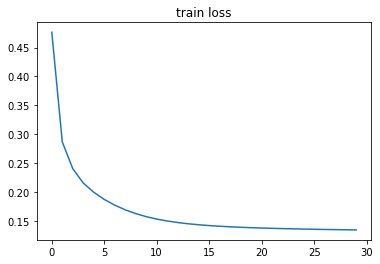

In [28]:
actor = train(net,train_iter,obj_function,optimizer,num_epochs=30)

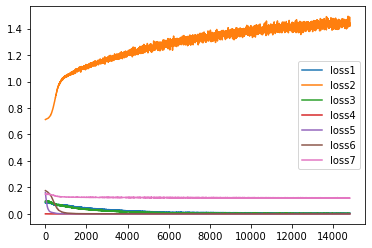

In [29]:
for k,v in loss_history.items():
    plt.plot(pd.Series(v).rolling(5).mean(),label=k)
plt.legend()
plt.show()

# build api

In [30]:
class PA_ROBOT:
    def __init__(self):
        self.mm_output = data['mm_output']
        self.mm_stream = data['mm_stream']
        self.mm_state = data['mm_state']
        self.mm_action = data['mm_action']
        self.action_col = data['action_col']
        self.tag_map = tag_map
        self.actor = actor
        self.critic = critic
        self.lasso_w = lasso_w
    
    def get_advice(self,state,request):
        
        # sacle input
        request = self.mm_output.transform([[request]])
        state = self.mm_state.transform([state])
        
        # tensor format input
        request = torch.FloatTensor([request]).reshape(-1,1)
        state = torch.FloatTensor(state)
        
        # actor forward
        action = self.actor(state,request)
        
        # critic forward but not predict stream
        output,_ = self.critic(state.cuda(),action.cuda())
        
        # lasso predict stream
        batch_size = action.shape[0]
        A = torch.cat((action.reshape(batch_size,-1),state),dim=-1)
        stream = (A@lasso_w).reshape(-1,1)
        
        # inverse transform
        output = output.detach().cpu().numpy()
        output = self.mm_output.inverse_transform(output)
        stream = stream.detach().cpu().numpy()
        stream = self.mm_stream.inverse_transform(stream)
        action = action.detach().cpu().numpy()
        action = np.array([self.mm_action.inverse_transform(i) for i in action]).squeeze(0)
        
        # create advice DataFrame
        advice = pd.DataFrame(index = self.action_col)
        advice['chinese'] = advice.index.map(self.tag_map) 
        advice['mean'] = action.mean(axis=0)
        advice['max'] = action.max(axis=0)
        advice['min'] = action.min(axis=0)
        
        # feed
        feed = advice.loc['MLPAP_FQ-0619.PV','mean']
        return advice,output,stream,feed/output[0][0],feed/stream[0][0]

In [31]:
robot = PA_ROBOT()

In [32]:
advice,output,stream,單耗,蒸氣單耗 = robot.get_advice([0.5,0.5],8000)
print('output:',output,'stream:',stream,'單耗',單耗,'蒸氣單耗',蒸氣單耗)
advice

output: [[8274.298]] stream: [[63534.305]] 單耗 0.8951154 蒸氣單耗 0.11657405


,chinese,mean,max,min
MLPAP_FQ-0619.PV,OX入料量,7406.451172,7406.824707,7406.209473
MLPAP_TJC-0627.PV,OX預熱器出口溫度,149.841141,149.844391,149.838531
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,181.856674,181.864883,181.849823
MLPAP_FR-0632.PV,汽機風量,79.727112,79.729607,79.723145
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,351.349304,351.351532,351.345398
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,47.535633,47.537048,47.534496
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,60.663559,60.665134,60.661900
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,181.860352,181.866257,181.854553
MLPAP_TRC-0747.PV,E220出口溫度,156.735199,156.752396,156.719788
MLPAP_TJ-0757B.PV,反應槽鹽浴溫度,351.145325,351.148163,351.143005


# save

In [33]:
joblib.dump(robot,'../model/PAagent.pkl')

['../model/PAagent.pkl']